In [27]:
%run analyses/imports.py

### 시계열 별 상세 결과 분석 및 시각화
- Metric 별로(주로 VUS-PR) 결과를 분석하는 도구
- 데이터 세트 단위 평균치가 아닌, 각 시계열에서 결과를 분석
- 지정된 경로의 모든 결과 파일을 읽어 VUS-PR과 Time을 leaderboard/에 기록
### TODO
- `plot_number_of_1st_ranked()`는 막대 그래프를 세 가지 색상으로만 분할 가능, 추후 N개 색상으로 분할 가능하도록 업데이트 (up to v0.5.0)
- `get_highlight_file_names()`에서 키워드를 '100'으로 지정 시 ID 외에 다른 부분에서 일치하여 반환되는 문제 있음 (up to v0.5.0)

#### 1. Leaderboard 기록
- `tup_idx`에 리더보드에 기록할 데이터 세트 인덱스 지정

In [28]:
def export_to_leaderboard_csv(dir_path, num_records=180):
    file_names = os.listdir(dir_path)
    file_names.sort()
    # create a DataFrame to store the results
    leaderboard_df = pd.DataFrame(columns=['Name', 'VUS-PR', 'Time'])
    for file_name in file_names:
        df = pd.read_csv(os.path.join(dir_path, file_name))
        
        if df.shape[0] < num_records:
            print(f"Skipping {file_name:60} due to insufficient records: {df.shape[0]}")
            continue

        # get name
        name = file_name.split('.')[0]
        
        # get mean VUS-PR
        mean_vus_pr = df['VUS-PR'].mean()

        # get mean time
        total_time = df['Time'].sum()

        # add record to the DataFrame
        leaderboard_df.loc[len(leaderboard_df)] = [name, mean_vus_pr, total_time]

    # save to csv
    dataset_type = dir_path.split('/')[-1]
    root_save_path = '/home/hwkang/dev-TSB-AD/TSB-AD/analyses/leaderboard'

    # sort by VUS-PR descending
    leaderboard_df.sort_values(by='VUS-PR', ascending=False, inplace=True)
    leaderboard_df.to_csv(os.path.join(root_save_path, f'leaderboard_vus_pr_{dataset_type}.csv'), index=False)

    # sort by Time ascending
    leaderboard_df.sort_values(by='Time', ascending=True, inplace=True)
    leaderboard_df.to_csv(os.path.join(root_save_path, f'leaderboard_time_{dataset_type}.csv'), index=False)

In [29]:
leaderboard_tup = [
    ('full', 180),
    ('msl', 7),
    ('smap', 25),
    # 1. 필요한 디렉터리 이름과 해당되는 레코드 수 추가
]
tup_idx = 0 # 2. 리스트에서 원하는 인덱스 선택
export_to_leaderboard_csv(f'{your_root_dir}/TSB-AD/results/{leaderboard_tup[tup_idx][0]}', num_records=leaderboard_tup[tup_idx][1])

Skipping 117_ParallelSNN_receptive_encoding.csv                       due to insufficient records: 46
Skipping 118_ParallelSNN_conv_encoding.csv                            due to insufficient records: 33
Skipping 119_ParallelSNN_delta_encoding.csv                           due to insufficient records: 33
Skipping 120_ParallelSNN_repeat_encoding.csv                          due to insufficient records: 44
Skipping 168_ParallelSNN_receptive_bn-k333-gradSpikeX.csv             due to insufficient records: 16
Skipping 169_ParallelSNN_receptive_bn-k333-gradSpikeO.csv             due to insufficient records: 16
Skipping 215_ParallelSNN_receptive_dtF-el5-ttT-dsF-geT.csv            due to insufficient records: 21
Skipping 216_ParallelSNN_receptive_dtF-el3-ttT-dsT-geT.csv            due to insufficient records: 20
Skipping 217_ParallelSNN_receptive_dtF-el5-ttT-dsT-geF.csv            due to insufficient records: 17
Skipping 218_ParallelSNN_receptive_dtF-el5-ttT-dsF-geF.csv            due to insuf

#### 2. 시계열 별 상세 분석

In [30]:
target_dir = 'full' # 원하는 디렉터리 이름 지정
src_dir_path = f'{your_root_dir}/TSB-AD/results/{target_dir}'

In [ ]:
keywords_to_include = [ # 분석할 모델 키워드 지정
    #'029', '077', '331', '332', '333_CNN', '334_CNN', '419', '420', '421', '422' # CNN, Full, norm-drop or CNN, MSL, norm-KPCA
    #'225', '354', '355', '070' # PW receptive, dynamic norm
    '077', '047', '176', '029', '442' # Full top-4
    #'029', '333_CNN', '361', '362', '363', '364', '369', '370', '371',  # Full receptive, dynamic, conv, delta repeat drop
    #'029', '077', '333_CNN', '391', '392', '393', '394' # Full, Dyanamic, channel-wise norm.+channel-drop
    #'029', '176', '400', '402', '280', '397' # Full, Dynamic, SPSN-EBCL vs. LBEC
    #'029', '077', '419', '420', '430', '431', '432', '440' # MSL, CNN, KMeansAD
    #'421', '422', '435', '441' # SMAP, CNN, KMeansAD
]
keywords_to_exclude = []

In [32]:
def csvs_to_dfs():
    file_names = os.listdir(src_dir_path)
    file_names.sort()
    file_paths = [os.path.join(src_dir_path, file_name) for file_name in file_names if file_name.endswith('.csv')]
    dfs = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        # Filter out rows based on keywords
        if any(keyword in file_path for keyword in keywords_to_include) and not any(keyword in file_path for keyword in keywords_to_exclude):
            #df = df[~df['file'].apply(lambda x: any(exclude in x for exclude in timeseries_to_exclude))]
            dfs.append(df)

    model_names = []
    for file_name in file_names:
        if any(keyword in file_name for keyword in keywords_to_include) and not any(keyword in file_name for keyword in keywords_to_exclude):
            # drop '.csv' from file name
            file_name = file_name.split('.csv')[0]
            splits = file_name.split('_')
            
            model_name = '_'.join(splits[0:2]+splits[-2:])
            model_names.append(model_name)

    file_paths = [file_path for file_path in file_paths if any(keyword in file_path for keyword in keywords_to_include) and not any(keyword in file_path for keyword in keywords_to_exclude)]
    return model_names, file_paths, dfs

def get_stat(df):
    return df['Time'].sum(), df['VUS-PR'].mean()
    

In [33]:
def plot_performance_heatmap(metric='VUS-PR',
                             highlight_file_names=None,
                             highlight_only: bool = False):
    # highlight_file_names: ['110','115','65'] 처럼 파일명에 매칭될 키워드 리스트
    if highlight_file_names is None:
        highlight_file_names = []

    # --- 기존 로직 그대로 ---
    dataframes_dict = {}
    for fp, model_name, df in zip(file_paths, model_names, dfs):
        #dataframes_dict[model_name] = pd.read_csv(fp)
        dataframes_dict[model_name] = df

    datasets = sorted({f for df in dataframes_dict.values() for f in df['file']})
    comparison_data = []
    for dataset in datasets:
        row = {'Dataset': dataset}
        for model, df in dataframes_dict.items():
            sel = df[df['file'] == dataset]
            row[model] = sel[metric].values[0] if not sel.empty else np.nan
        comparison_data.append(row)
    comparison_df = pd.DataFrame(comparison_data).set_index('Dataset')
    comparison_df.loc['Mean'] = comparison_df.mean()

    # highlight_only 가 True 면 highlight_file_names 에 포함된 데이터만 남김
    if highlight_only and highlight_file_names:
        comparison_df = comparison_df.loc[
            comparison_df.index.isin(highlight_file_names)
        ]
        comparison_df.loc['Mean'] = comparison_df.mean()

    # --- heatmap 그리기 ---
    plt.figure(figsize=(12, len(comparison_df) * 0.3))
    ax = sns.heatmap(
        comparison_df,
        annot=True, fmt='.3f', cmap='viridis',
        cbar_kws={'label': metric}
    )
    plt.title(f'Comparison of {metric} Across Models')
    if len(file_paths) >= 3:
        plt.xticks(rotation=45, ha='right')

    # --- y축 레이블 하이라이트 (highlight_only=False 일 때만 적용) ---
    if not highlight_only and highlight_file_names:
        for lbl in ax.get_yticklabels():
            txt = lbl.get_text()
            if any(key == txt or key in txt for key in highlight_file_names):
                lbl.set_color('red')

    if len(file_paths) >= 4:
        plt.tight_layout()
    
    return comparison_df

In [34]:
def plot_number_of_1st_ranked(metric='VUS-PR', red_files=None, green_files=None, **kwargs):
    if red_files is None:
        red_files = []
    if green_files is None:
        green_files = []

    # --- comparison_df 구성 (생략) ---
    dataframes_dict = {m: df for m, fp, df in zip(model_names, file_paths, dfs)}
    datasets = sorted({f for df in dataframes_dict.values() for f in df['file']})
    rows = []
    for ds in datasets:
        row = {'Dataset': ds}
        for m, df in dataframes_dict.items():
            sel = df[df['file'] == ds]
            row[m] = sel[metric].values[0] if not sel.empty else np.nan
        rows.append(row)
    comparison_df = pd.DataFrame(rows).set_index('Dataset')

    # --- 전체 1위 카운트 ---
    total_counts = {}
    for ds, row in comparison_df.iterrows():
        m0 = row.idxmax()
        total_counts[m0] = total_counts.get(m0, 0) + 1

    # --- red_files 1위 카운트 ---
    red_counts = {}
    for ds, row in comparison_df.loc[comparison_df.index.isin(red_files)].iterrows():
        m0 = row.idxmax()
        red_counts[m0] = red_counts.get(m0, 0) + 1

    # --- green_files 1위 카운트 ---
    green_counts = {}
    for ds, row in comparison_df.loc[comparison_df.index.isin(green_files)].iterrows():
        m0 = row.idxmax()
        green_counts[m0] = green_counts.get(m0, 0) + 1

    # --- 모델을 total_counts 기준 내림차순 정렬 ---
    sorted_models = sorted(total_counts.items(),
                           key=lambda x: x[1],
                           reverse=True)
    models, _ = zip(*sorted_models)

    # 각 모델별 값 추출
    red_vals   = [red_counts.get(m, 0) for m in models]
    green_vals = [green_counts.get(m, 0) for m in models]
    other_vals = [total_counts[m] - red_vals[i] - green_vals[i]
                  for i, m in enumerate(models)]

    # --- 3단계 스택 바 차트 ---
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(models, other_vals,
           label='Others', color='skyblue')
    ax.bar(models, green_vals,
           bottom=other_vals,
           label=kwargs.get('green_label', 'Green'), color='lightgreen')
    bottom_rg = [other_vals[i] + green_vals[i] for i in range(len(models))]
    ax.bar(models, red_vals,
           bottom=bottom_rg,
           label=kwargs.get('red_label', 'Red'), color='salmon')
    
    # bar에 숫자 값 표시
    for i, (m, o, g, r) in enumerate(zip(models, other_vals, green_vals, red_vals)):
        ax.text(i, o + g + r + 0.1, f'{o+g+r}', ha='center', va='bottom')

    ax.set_title(f'Number of 1st Ranked Models by {metric}')
    ax.set_xlabel('Model')
    ax.set_ylabel('Count of 1st Ranks')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [35]:
def get_highlight_file_names(file_name_to_include: list):
    assert len(file_name_to_include) > 0, "file_name_to_include must not be empty"
    highlight_file_names = [f_name for f_name in os.listdir(f'{your_root_dir}/TSB-AD/Datasets/TSB-AD-M')]
    highlight_file_names.sort()
    #highlight_file_names = [f_name for f_name in highlight_file_names if any(f_name.startswith(prefix) for keyword in file_name_to_include)]
    highlight_file_names = [f_name for f_name in highlight_file_names if any(keyword in f_name for keyword in file_name_to_include)]
    return highlight_file_names

In [36]:
model_names, file_paths, dfs = csvs_to_dfs()

In [37]:
print(f'Model name | Path')
for m_name, f_path in zip(model_names, file_paths):
    print(f"{m_name:50} | {f_path}")

Model name | Path
029_CNN_None_None                                  | /home/hwkang/dev-TSB-AD/TSB-AD/results/full/029_CNN_None_None.csv
047_ParallelSNN_repeat_full-snntorch               | /home/hwkang/dev-TSB-AD/TSB-AD/results/full/047_ParallelSNN_repeat_full-snntorch.csv
077_PCA_None_None                                  | /home/hwkang/dev-TSB-AD/TSB-AD/results/full/077_PCA_None_None.csv
176_ParallelSNN_receptive_ln-k357-gradSpikeX       | /home/hwkang/dev-TSB-AD/TSB-AD/results/full/176_ParallelSNN_receptive_ln-k357-gradSpikeX.csv
442_KMeansAD_None_full-KMeansAD                    | /home/hwkang/dev-TSB-AD/TSB-AD/results/full/442_KMeansAD_None_full-KMeansAD.csv


##### 2.1 선택된 데이터 중에서 랭킹 분석
- Top-5 출력

In [38]:
ranking = []
for model_name, df in zip(model_names, dfs):
    total_runtime, mean_score = get_stat(df)
    #print(f'{model_name}: score: {mean_score:.4f}, runtime: {total_runtime:.2f}, efficiency: {mean_score/total_runtime:.4e}')
    ranking.append((model_name, total_runtime, mean_score))

print('\nranking (sorted by score):')
ranking.sort(key=lambda x: x[2], reverse=True)
for i, (model_name, total_runtime, mean_score) in enumerate(ranking):
    # only top-5
    if i < 16:
        print(f'{i+1}. {model_name:50} | score: {mean_score:.4f} | runtime: {total_runtime:10.2f} | efficiency: {mean_score/total_runtime:.4e}')
    else:
        break

print('\nranking (sorted by runtime):')
ranking.sort(key=lambda x: x[1])
for i, (model_name, total_runtime, mean_score) in enumerate(ranking):
    if i < 16:    
        print(f'{i+1}. {model_name:50} | score: {mean_score:.4f} | runtime: {total_runtime:10.2f} | efficiency: {mean_score/total_runtime:.4e}')
    else:
        break


ranking (sorted by score):
1. 077_PCA_None_None                                  | score: 0.4233 | runtime:   24782.01 | efficiency: 1.7081e-05
2. 047_ParallelSNN_repeat_full-snntorch               | score: 0.3783 | runtime:   13049.32 | efficiency: 2.8991e-05
3. 176_ParallelSNN_receptive_ln-k357-gradSpikeX       | score: 0.3669 | runtime:   19254.61 | efficiency: 1.9057e-05
4. 029_CNN_None_None                                  | score: 0.3587 | runtime:    9030.89 | efficiency: 3.9724e-05
5. 442_KMeansAD_None_full-KMeansAD                    | score: 0.2950 | runtime:   13536.45 | efficiency: 2.1790e-05

ranking (sorted by runtime):
1. 029_CNN_None_None                                  | score: 0.3587 | runtime:    9030.89 | efficiency: 3.9724e-05
2. 047_ParallelSNN_repeat_full-snntorch               | score: 0.3783 | runtime:   13049.32 | efficiency: 2.8991e-05
3. 442_KMeansAD_None_full-KMeansAD                    | score: 0.2950 | runtime:   13536.45 | efficiency: 2.1790e-05
4. 176

#### 2.2 막대 그래프 시각화
- 선택된 모델 중 각 시계열 별로 가장 성능이 좋은 시계열의 수를 카운트하여 막대 그래프로 출력
- 막대 그래프가 높을 수록 성능이 1등인 시계열이 많았다는 것을 의미

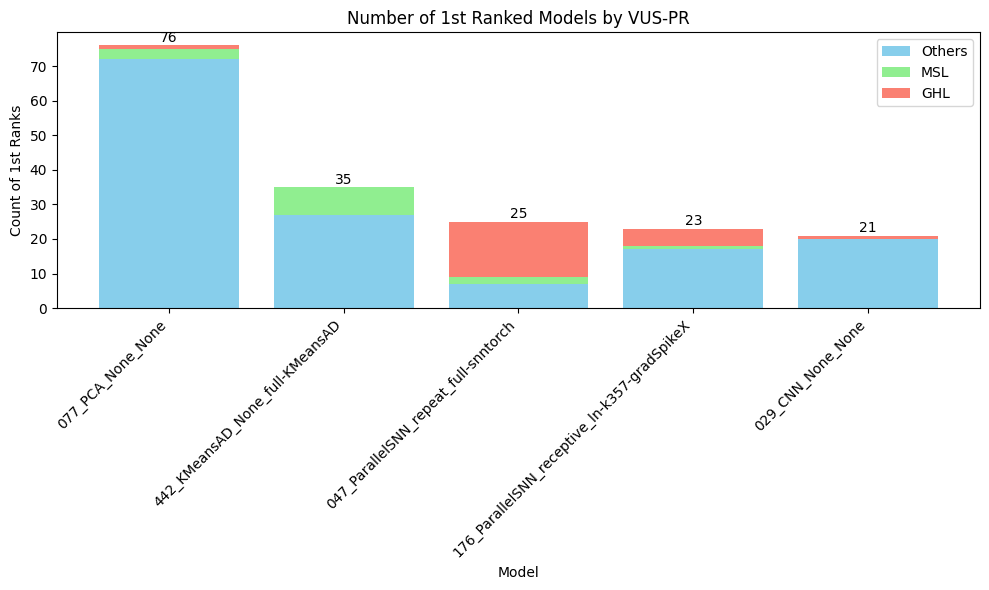

In [39]:
# 막대 그래프에 red_files와 green_files 안에 있는 시계열의 비중을 파악하기 위함
red_files = get_highlight_file_names(
    ['GHL']
)
green_files = get_highlight_file_names(
    ['MSL']
)

# red와 green에 대한 라벨 명시
plot_number_of_1st_ranked(red_files=red_files, green_files=green_files, red_label='GHL', green_label='MSL')

#### 2.3 히트맵 시각화
- `highlight_only`인자에 `False` 입력 시 강조하고 싶은 파일 이름이 있다면 붉게 표시됨
- `highlight_only`인자에 `True` 입력 시 강조하고 싶은 파일만 시각화됨

In [40]:
# 강조할 파일의 이름 또는 코드를 리스트에 추가
# Example
# 1) 키워드로 지정: file_name_to_include = ['001', '002', '040', ...] 또는 ['Genesis', 'MSL', ...]
# 2) 파일 이름으로 지정: file_name_to_include = ['001_Genesis_id_1_Sensor_tr_4055_1st_15538.csv', ...]
# 3) 정수 범위로 지정: file_name_to_include = [f'0{str(f_code):}' if f_code < 100 else f'{str(f_code)}' for f_code in list(range(100, 102))]
#file_name_to_include = [f'0{str(f_code):}' if f_code < 100 else f'{str(f_code)}' for f_code in list(range(100, 102))]
file_name_to_include = ['GHL']
highlight_file_names = get_highlight_file_names(file_name_to_include)

,029_CNN_None_None,047_ParallelSNN_repeat_full-snntorch,077_PCA_None_None,176_ParallelSNN_receptive_ln-k357-gradSpikeX,442_KMeansAD_None_full-KMeansAD
Dataset,,,,,
001_Genesis_id_1_Sensor_tr_4055_1st_15538.csv,0.050816,0.018388,0.010594,0.062286,0.890927
002_MSL_id_1_Sensor_tr_500_1st_900.csv,0.146176,0.141821,0.525392,0.147663,0.996066
003_MSL_id_2_Sensor_tr_883_1st_1238.csv,0.176308,0.182515,0.122399,0.169274,0.300985
005_MSL_id_4_Sensor_tr_855_1st_2700.csv,0.082126,0.075741,0.130184,0.089327,0.113204
006_MSL_id_5_Sensor_tr_1150_1st_1250.csv,0.101872,0.107411,0.056506,0.101264,0.289077
...,...,...,...,...,...
197_Exathlon_id_24_Facility_tr_10766_1st_12590.csv,0.950172,0.943397,0.975432,0.954735,0.174261
198_Exathlon_id_25_Facility_tr_12538_1st_12638.csv,0.974817,0.976011,0.978164,0.952227,0.348511
199_Exathlon_id_26_Facility_tr_12538_1st_12638.csv,0.973162,0.987452,0.978164,0.957687,0.348517


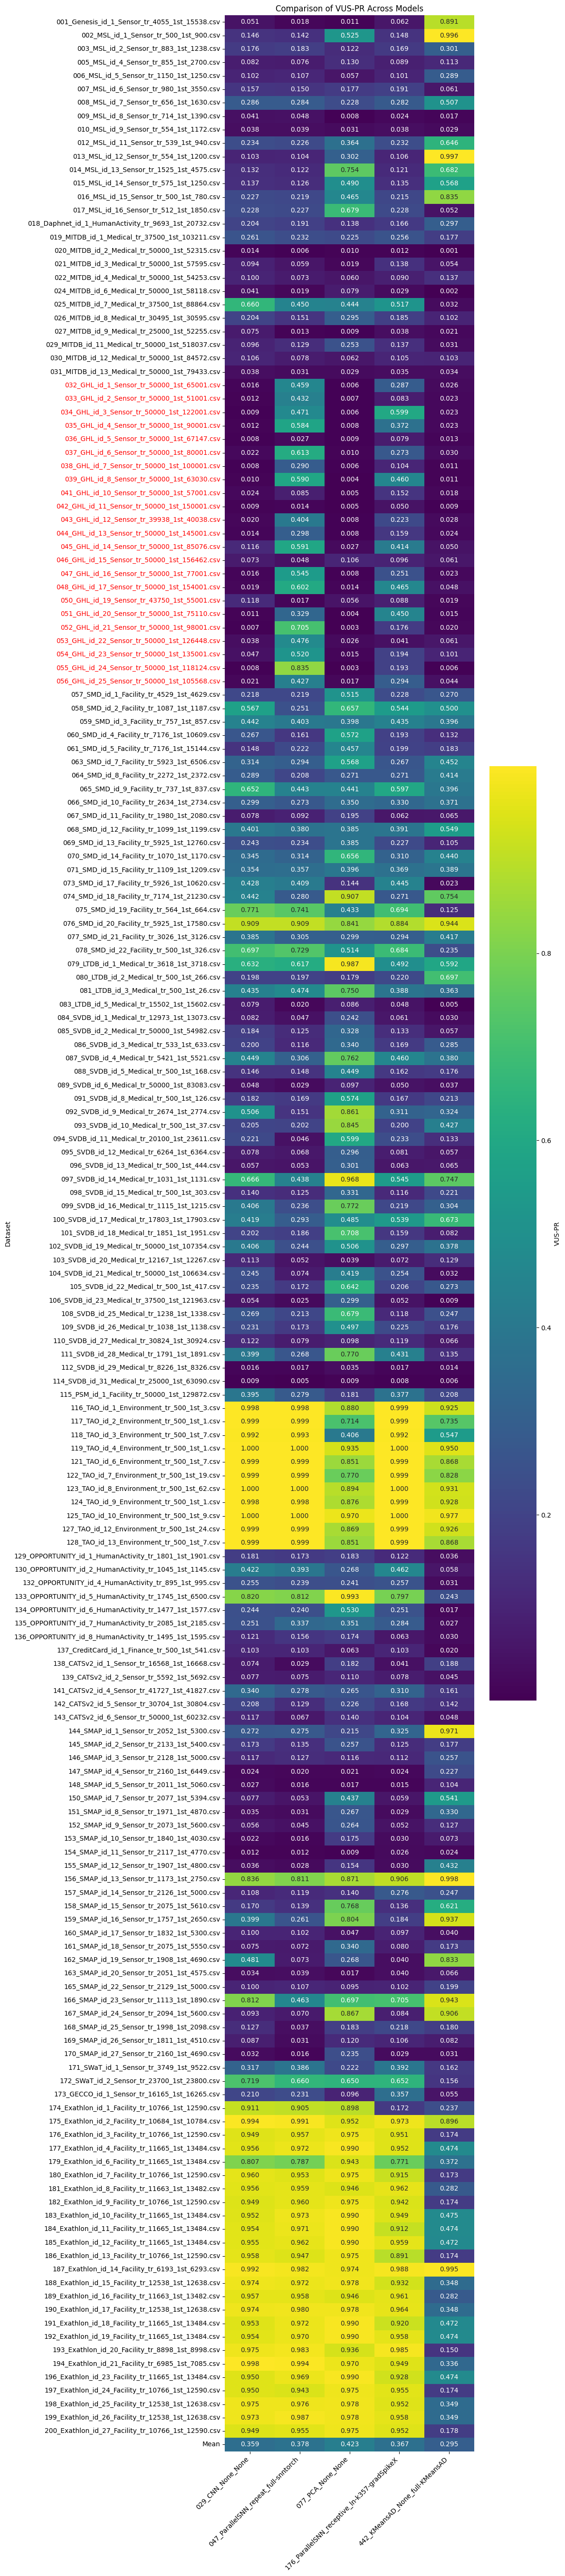

In [41]:
# 하이라이트를 포함하여 출력
plot_performance_heatmap(highlight_file_names=highlight_file_names, highlight_only=False)

,029_CNN_None_None,047_ParallelSNN_repeat_full-snntorch,077_PCA_None_None,176_ParallelSNN_receptive_ln-k357-gradSpikeX,442_KMeansAD_None_full-KMeansAD
Dataset,,,,,
032_GHL_id_1_Sensor_tr_50000_1st_65001.csv,0.016036,0.458929,0.005670,0.287186,0.026426
033_GHL_id_2_Sensor_tr_50000_1st_51001.csv,0.011759,0.431701,0.006703,0.083008,0.022946
034_GHL_id_3_Sensor_tr_50000_1st_122001.csv,0.008849,0.470900,0.006165,0.599252,0.022664
035_GHL_id_4_Sensor_tr_50000_1st_90001.csv,0.011676,0.583996,0.007962,0.371823,0.022905
036_GHL_id_5_Sensor_tr_50000_1st_67147.csv,0.008368,0.026784,0.009261,0.079149,0.013373
037_GHL_id_6_Sensor_tr_50000_1st_80001.csv,0.022380,0.613498,0.009501,0.273169,0.030471
038_GHL_id_7_Sensor_tr_50000_1st_100001.csv,0.008430,0.289859,0.005709,0.104382,0.011339
039_GHL_id_8_Sensor_tr_50000_1st_63030.csv,0.010462,0.590452,0.003598,0.459800,0.011052
041_GHL_id_10_Sensor_tr_50000_1st_57001.csv,0.023797,0.084810,0.005275,0.151529,0.017758


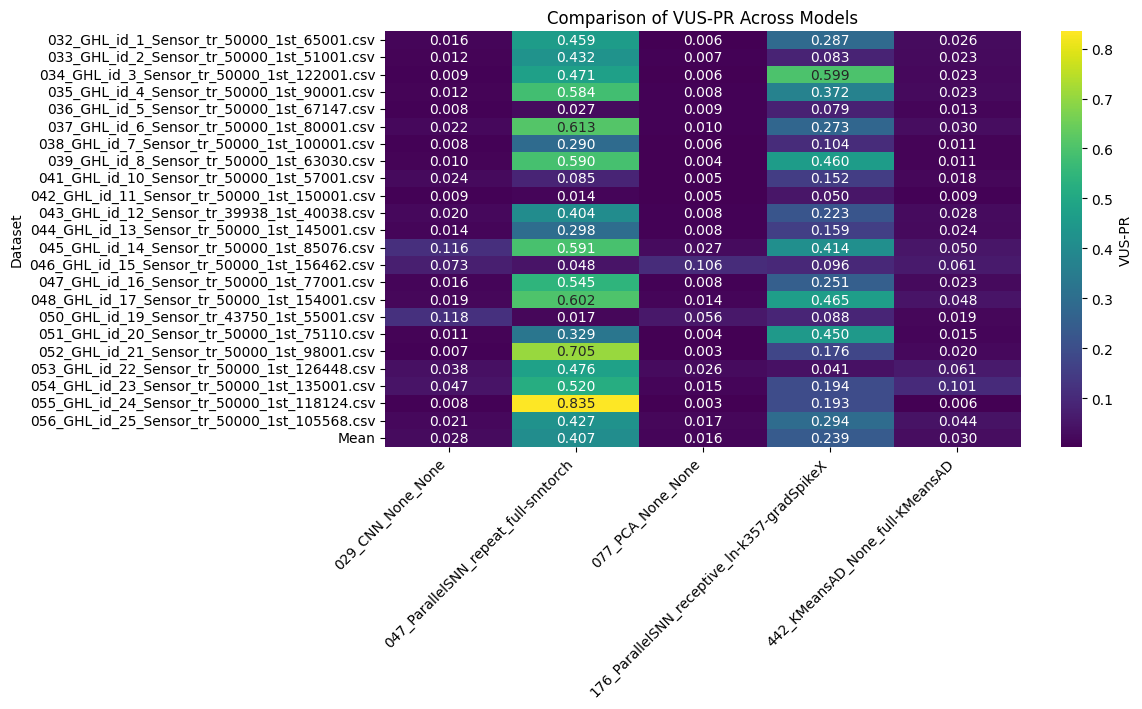

In [42]:
# 하이라이트 결과만 출력
plot_performance_heatmap(highlight_file_names=highlight_file_names, highlight_only=True)